In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Updating files: 100% (4/4)
Updating files: 100% (4/4), done.


In [3]:
!dir german-traffic-signs

 Volume in drive C is Windows
 Volume Serial Number is D453-627B

 Directory of C:\Users\Hp\Desktop\Traffic-Sign-Detection-and-Classification\Classifier Models training\german-traffic-signs

24/05/23  22:00    <DIR>          .
24/05/23  22:00    <DIR>          ..
24/05/23  22:00             1,043 signnames.csv
24/05/23  22:00        38,888,118 test.p
24/05/23  22:00       107,146,452 train.p
24/05/23  22:00        13,578,712 valid.p
               4 File(s)    159,614,325 bytes
               2 Dir(s)  79,906,783,232 bytes free


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import pickle
import random
import pandas as pd

In [7]:
np.random.seed(0)

In [8]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))


X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


<class 'dict'>


In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [10]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32*32*3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32*32*3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32*32*3"

IndexError: index 480 is out of bounds for axis 0 with size 480

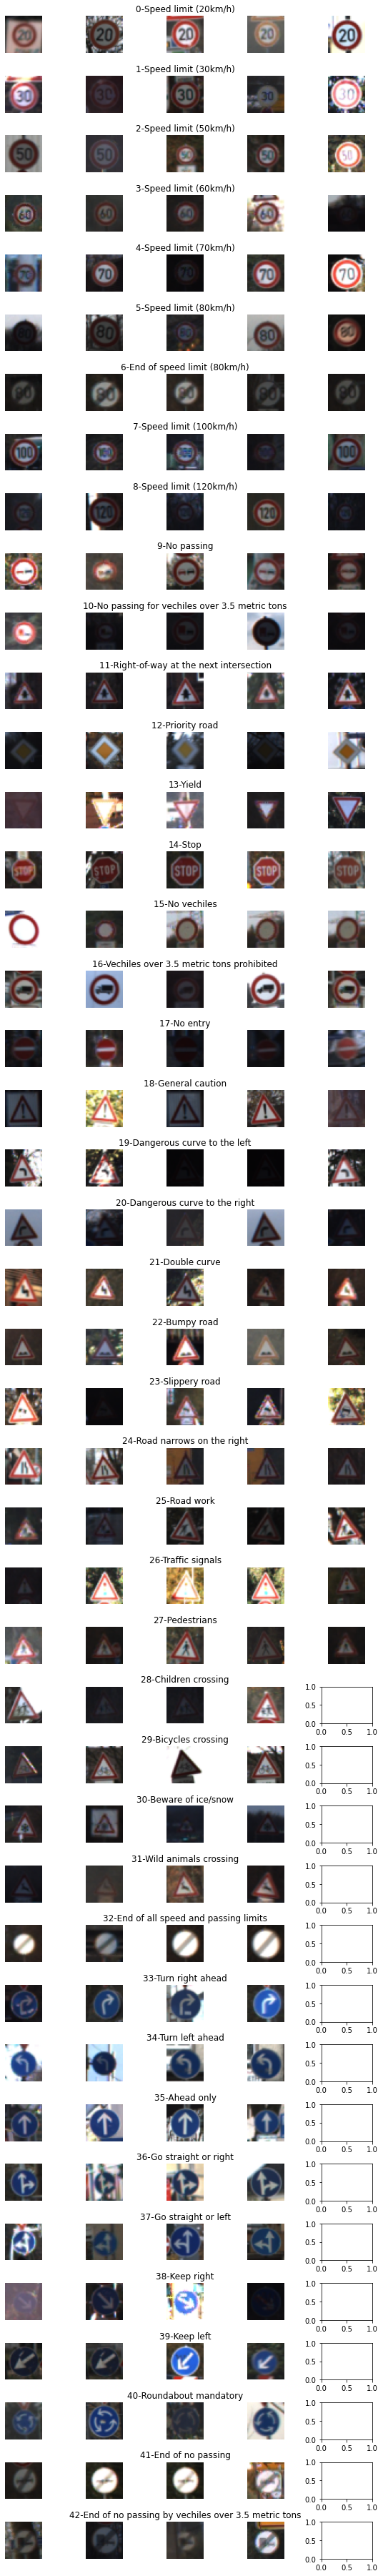

In [11]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(8, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))



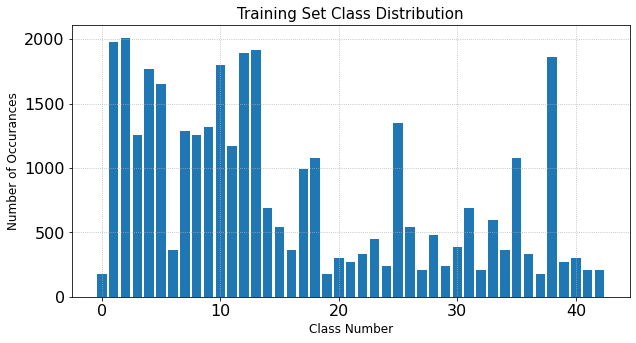

In [13]:

fig = plt.figure(0, figsize = (10,5))
unique_train, counts_train = np.unique(y_train, return_counts = True)
plt.bar(unique_train, counts_train)

plt.title('Training Set Class Distribution', fontsize=15)
plt.xlabel('Class Number', fontsize=12)
plt.ylabel('Number of Occurances', fontsize=12)
plt.tick_params(labelsize=16)
plt.grid(linestyle=':')

fig.savefig('number_of_samples.png')

(32, 32, 3)
36


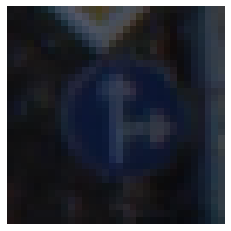

In [14]:
import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

In [15]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img


(32, 32)


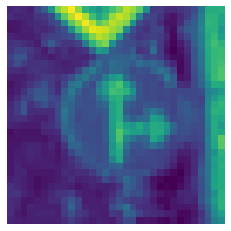

In [16]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


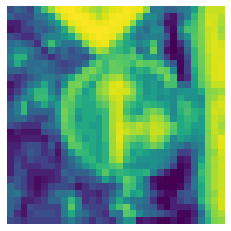

In [17]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [18]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


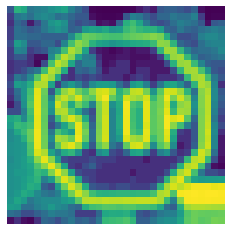

In [19]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [20]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [21]:
from keras.preprocessing.image import  ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range= 0.1, 
                             height_shift_range= 0.1, 
                             zoom_range= 0.2, 
                             shear_range= 0.1, 
                             rotation_range= 10)
datagen.fit(X_train)

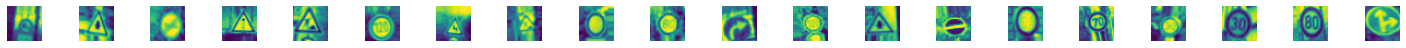

In [22]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 20, figsize= (20, 5))
fig.tight_layout()

for i in range(20):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [24]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [28]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(rate=0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))
  #model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [29]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [ ]:
# batch_size = 50
# h = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=int(len(X_train)/batch_size), epochs=20, validation_data=datagen.flow(X_val, y_val, batch_size=50), validation_steps=int(len(X_val)/batch_size), shuffle=1)

In [ ]:
# batch_size = 50
# h = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=len(X_train)//batch_size, epochs=10, validation_data=(X_val, y_val), shuffle=1)

In [30]:
batch_size = 16
h = model.fit(datagen.flow(X_train, y_train, batch_size=16), steps_per_epoch=int(len(X_train)/batch_size) , epochs=30, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/30
2174/2174 [==============================] - 216s 91ms/step - loss: 2.3390 - accuracy: 0.3518 - val_loss: 0.2796 - val_accuracy: 0.9086
Epoch 2/30
2174/2174 [==============================] - 223s 103ms/step - loss: 0.5118 - accuracy: 0.8405 - val_loss: 0.0888 - val_accuracy: 0.9766
Epoch 3/30
1752/2174 [=======================>......] - ETA: 41s - loss: 0.3319 - accuracy: 0.8949

KeyboardInterrupt: 

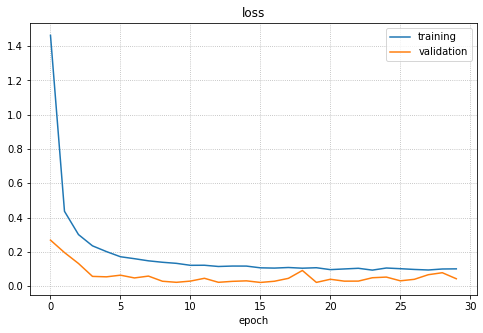

In [ ]:
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(8, 5)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.grid(linestyle=':')

# fig.savefig('/content/Loss.svg')

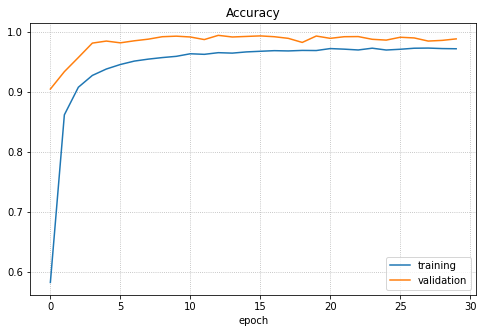

In [ ]:
fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(8, 5)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.grid(linestyle=':')

#fig.savefig('/content/Accuracy.svg')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.1737435758113861
Test Accuracy:  0.9688044190406799


In [ ]:
model.save("/content/model_modified_1.h5")

## Testing of model

### test images

In [ ]:
# https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

# https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

# https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

# https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

# https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg



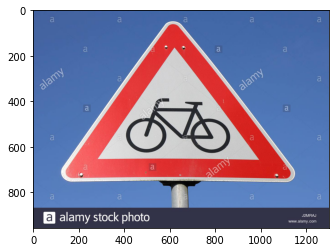

In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


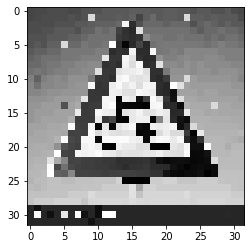

In [ ]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape image
 
img = img.reshape(1, 32, 32, 1)

In [ ]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predicted sign: [30]
